# Colorizing Images

In this notebook we are going to use two different networks for colorizing black and white images. Both approaches solve a regression task. Again we will work with the simpson dataset.

Inspired by:
* https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d
* https://github.com/baldassarreFe/deep-koalarization


## Imports

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
from skimage import io, color
from skimage.transform import resize
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, InputLayer, UpSampling2D, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import RepeatVector, Reshape, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

####  Setup



In [ ]:
import os,sys

if "google.colab" in sys.modules:
    %pip install wget

import wget,zipfile

if "labsetup_run" not in locals() or labsetup_run:

    print("running setup ...")

    # download data.zip from shared google drive
    if not(os.path.isfile("data.zip")):
        filename=wget.download("https://drive.google.com/uc?export=download&confirm=yes&id=1dkSV2oL8Ua1SDmzVvtGkyQ0LGQ6VpUIy")
    # unpack it
    if not(os.path.isdir("./data")):
        zf = zipfile.ZipFile(os.path.join(".","data.zip"), "r")
        zf.extractall()

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    print("done.")
    labsetup_run = False  # change to True re-run setup
else:
    print("setup already run.")


#### Load Data

We will only need the pictures without the labels. For this task we do not need a validationset. So we just add it to the train set.

In [ ]:
path="./data/simpson_data"

Data = pd.read_csv(os.path.join(path,"Data.csv"))

rgb_train = np.concatenate((np.load(os.path.join(path,"X_train.npy")), np.load(os.path.join(path,"X_val.npy"))))
rgb_test = np.load(os.path.join(path,"X_test.npy"))
Y_train = np.concatenate((np.load(os.path.join(path,"Y_train.npy")), np.load(os.path.join(path,"Y_val.npy"))))
Y_test = np.load(os.path.join(path,"Y_test.npy"))

print(rgb_train.shape)
print(rgb_test.shape)


## Change color space to LAB

The pictures are now in RGB and if we would want to colorize the graysacale images we would have to predict 3 different channels. This means that theoretically per pixel we would have 256^3 (16.7 million) combination to choose from.

If we change the colorspace to LAB (Lightness/grayscale, green-red, yellow-blue) we can reduce the number of combinations per pixel significantly, down to 256^2 (65'500) combinations.


In [ ]:
lab_train = color.rgb2lab(rgb_train).astype("float32")
lab_test = color.rgb2lab(rgb_test).astype("float32")

print(lab_train.shape)
print(lab_test.shape)


### Normalize Input

In [ ]:
l_train = lab_train[:, :, :, 0:1] / 50. - 1. # Between -1 and 1
ab_train = lab_train[:, :, :, 1:3] / 110. # Between -1 and 1

l_test = lab_test[:, :, :, 0:1] / 50. - 1. # Between -1 and 1
ab_test = lab_test[:, :, :, 1:3] / 110. # Between -1 and 1

print(l_train.shape)
print(ab_train.shape)
print(l_test.shape)
print(ab_test.shape)

## Regression approach

So first were going to do a simple regression approach to the problem. We define our own CNN and do a downsampling followed by upsampling. We're also going to use data augmentation.

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(80, 80, 1)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.summary()

model.compile(optimizer='rmsprop', loss='mse')


In [ ]:
# Image transformer
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [ ]:
history = model.fit(datagen.flow(l_train, ab_train, batch_size=32),
                              steps_per_epoch=len(l_train)/32,
                              epochs=50, #50
                              validation_data=(l_test, ab_test),
                              verbose=2)


In [ ]:
# summarize history for loss (this is useless if you just train for one epoch)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
ab_test_pred = model.predict(l_test)

In [ ]:
# function to plot the original, gray scale and predicted image.
def plot_orig_gray_pred(pic_num):
  canvas = np.zeros((80, 80, 3))
  canvas[:,:,0] = lab_test[pic_num, :, :, 0]
  canvas[:,:,1:] = ab_test_pred[pic_num]*110

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

  ax1.imshow(rgb_test[pic_num], cmap=plt.cm.gray)
  ax1.set_title('Orignal image')

  ax2.imshow(color.rgb2gray(rgb_test[pic_num]), cmap="gray")
  ax2.set_title('Gray image')

  ax3.imshow(color.lab2rgb(canvas), cmap=plt.cm.gray)
  ax3.set_title('Colorized image')

In [ ]:
for i in range(10):
  plot_orig_gray_pred(i)


Alright, it looks like after one epoch the Neural Network is only able to shade the faces a bit yellow but the rest of the image has always the same color. If 2 or 3 epochs are trained the yellow shade tends to be more image centred. And if it's trained for 10 to 50 epochs the faces are mostly yellow and often the network paints the hairs of march blue. But the backgroud is still just brownish.

## Enocoder-Decoder approach

Now we are going to build a more sophisticated approach.
We will use an encoder-decoder architecture and also use a pretrained cnn network which is able to classfiy the black and white simpson character with an accuracy of ~90%.

The architecture looks similar to the one below (we just changed the inception ResNet). The original network is from: https://github.com/baldassarreFe/deep-koalarization

For this you will have to use the "simpson_cnn_bw.h5" file from the data folder

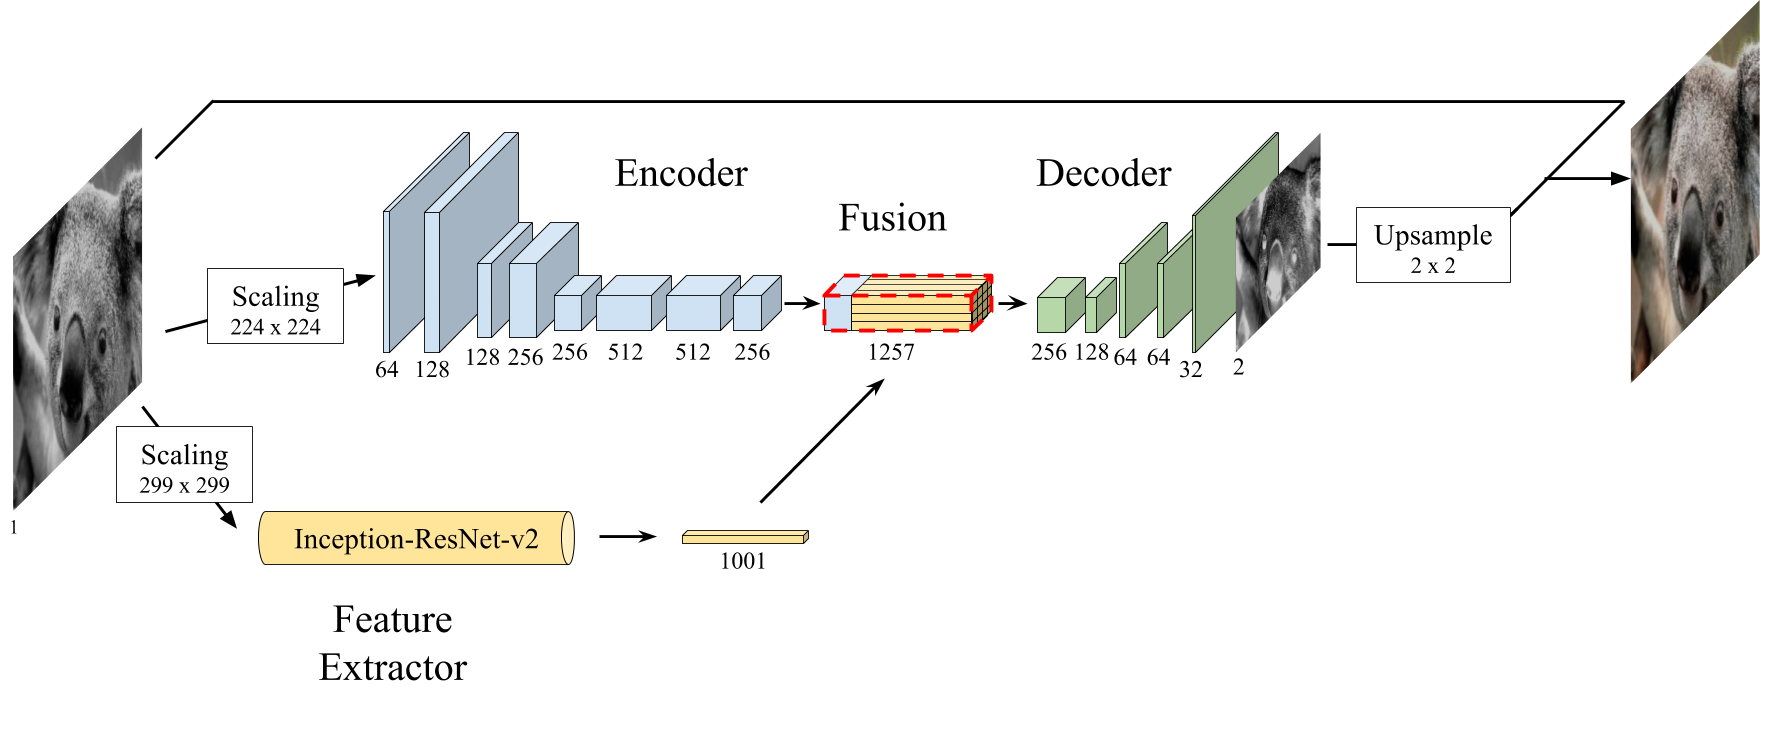

Deep Koalarization Network (https://github.com/baldassarreFe/deep-koalarization)

Let us build the model.

In [ ]:
#Load weights
# inception = InceptionResNetV2(weights='imagenet', include_top=True)
character_cnn = load_model("./data/simpson_data/simpsons_cnn_bw.h5")
# inception.graph = tf.compat.v1.get_default_graph()

embed_input = Input(shape=(14,))

#Encoder
encoder_input = Input(shape=(80, 80, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(10 * 10)(embed_input)
fusion_output = Reshape(([10, 10, 14]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model.compile(optimizer='adam', loss='mse')

model.summary()


Let's check the accuracy on our testset.

In [ ]:
character_pred_test = character_cnn.predict(l_test)
acc = np.average(np.argmax(character_pred_test, axis=1) == np.argmax(Y_test,axis=1))
print(acc)

In [ ]:
# Image transformer
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

In [ ]:
# Train the model
history = model.fit(datagen.flow([l_train, character_cnn.predict(l_train)],
                                 ab_train,
                                 batch_size=16),
                    steps_per_epoch=len(l_train)/16,
                    validation_data=([l_test, character_pred_test], ab_test),
                    epochs=150, # 150
                    verbose=2)

In [ ]:
# summarize history for loss (this is useless if you just train for one epoch)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
lw_pic_range = 0
up_pic_range = 50

embed_test = character_cnn.predict(l_test[lw_pic_range:up_pic_range])

ab_test_pred = model.predict([l_test[lw_pic_range:up_pic_range], embed_test])

In [ ]:
for i in range(10):
  plot_orig_gray_pred(i)

It looks better than the other network but still not great.

## Now it's your turn

* Tweek the network so the images look more realistic.
* Use another pretrained-model. But keep in mind that your model has to work with black and white pictures.
* Try a different dataset. For this you will probably have to change the input sizes.
* Maybe another network will work better. In this paper https://arxiv.org/abs/1603.08511 instead of a regression problem a classification problem is solved.